# Phase 4: Advanced Models & Ensembles

This notebook implements advanced models and ensemble methods to achieve target performance.

**Objectives:**
- Train tuned LightGBM with optimized hyperparameters
- Train XGBoost model
- Train CatBoost model
- Compare all models (baseline + advanced)
- Analyze feature importance
- Evaluate gap to target RMSPE (0.09856)

**Models:**
1. Tuned LightGBM (optimized hyperparameters)
2. XGBoost (gradient boosting alternative)
3. CatBoost (handles categoricals natively)

## Setup

In [ ]:
import sys
from pathlib import Path

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import json

from evaluation.cv import (
    make_time_series_folds,
    filter_open_stores
)
from evaluation.reporting import (
    save_cv_results,
    print_cv_summary,
    compare_models
)
from models.train_baselines import get_feature_columns
from models.train_advanced import (
    tuned_lightgbm_model,
    xgboost_model,
    catboost_model,
    get_feature_importance
)
from utils.io import read_parquet, ensure_dir

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Ensure output directories
ensure_dir('../outputs/metrics/advanced')

print("Setup complete!")

Setup complete!


## 1. Load Data and Create CV Folds

In [ ]:
# Load featured data
df = read_parquet('../data/processed/train_features.parquet')

print(f"Loaded data shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

Loaded data shape: (1017209, 50)
Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00


In [ ]:
# Load CV config
with open('../config/params.yaml', 'r') as f:
    params = yaml.safe_load(f)

cv_config = params['cv']

print("Cross-Validation Configuration:")
print(f"  N folds: {cv_config['n_folds']}")
print(f"  Fold length: {cv_config['fold_length_days']} days")

Cross-Validation Configuration:
  N folds: 5
  Fold length: 42 days


In [ ]:
# Filter and create folds
df_open = filter_open_stores(df)

# Create folds using only valid parameters
folds = make_time_series_folds(
    df_open,
    n_folds=cv_config['n_folds'],
    fold_length_days=cv_config['fold_length_days'],
    min_train_days=cv_config['min_train_days']
)

feature_cols = get_feature_columns(df_open)

print(f"Created {len(folds)} folds")
print(f"Features: {len(feature_cols)}")

2025-12-01 10:07:38 - evaluation.cv - INFO - Filtered out 172,817 closed store-days (16.99%)
2025-12-01 10:07:38 - evaluation.cv - INFO - Remaining: 844,392 open store-days
2025-12-01 10:07:38 - evaluation.cv - INFO - ============================================================
2025-12-01 10:07:38 - evaluation.cv - INFO - Creating time-series cross-validation folds
2025-12-01 10:07:38 - evaluation.cv - INFO - ============================================================
2025-12-01 10:07:38 - evaluation.cv - INFO - Number of folds: 5
2025-12-01 10:07:38 - evaluation.cv - INFO - Validation fold length: 42 days (6 weeks)
2025-12-01 10:07:38 - evaluation.cv - INFO - Minimum training days: 365 days (1 year)
2025-12-01 10:07:38 - evaluation.cv - INFO - Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00
2025-12-01 10:07:38 - evaluation.cv - INFO - Total unique dates: 942
2025-12-01 10:07:38 - evaluation.cv - INFO - 
First validation period starts at: 2014-01-01 00:00:00
2025-12-01 10:07:38

## 2. Train Tuned LightGBM Model

In [ ]:
# Train tuned LightGBM
lgb_tuned_results = tuned_lightgbm_model(
    df_open, 
    folds, 
    feature_cols,
    params=params["models"]["advanced_lightgbm"]
)

# Print summary
print_cv_summary(lgb_tuned_results)

2025-12-01 10:07:38 - models.train_advanced - INFO - ============================================================
2025-12-01 10:07:38 - models.train_advanced - INFO - Training Tuned LightGBM Model
2025-12-01 10:07:38 - models.train_advanced - INFO - ============================================================
2025-12-01 10:07:38 - models.train_advanced - INFO - Number of features: 46
2025-12-01 10:07:38 - models.train_advanced - INFO - Parameters: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'num_leaves': 50, 'learning_rate': 0.03, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'bagging_freq': 5, 'max_depth': 8, 'min_child_samples': 20, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'num_boost_round': 2000, 'early_stopping_rounds': 100}
2025-12-01 10:07:38 - evaluation.cv - INFO - Removed 25,547 rows with missing features (7.56%)
2025-12-01 10:07:38 - evaluation.cv - INFO - Remaining: 312,396 complete rows
2025-12-01 10:07:38 - evaluation.cv - INFO - Removed 0 rows w

In [ ]:
# Save results
save_cv_results(lgb_tuned_results, "lightgbm_tuned", "../outputs/metrics/advanced")
print("Saved tuned LightGBM results")

2025-12-01 10:08:48 - evaluation.reporting - INFO - Saved CV results to ../outputs/metrics/advanced/lightgbm_tuned_cv_results.json
Saved tuned LightGBM results


## 3. Train XGBoost Model

In [ ]:
# Train XGBoost
xgb_results = xgboost_model(
    df_open,
    folds,
    feature_cols,
    params=params["models"]["advanced_xgboost"]
)

# Print summary
print_cv_summary(xgb_results)

2025-12-01 10:08:48 - models.train_advanced - INFO - ============================================================
2025-12-01 10:08:48 - models.train_advanced - INFO - Training XGBoost Model
2025-12-01 10:08:48 - models.train_advanced - INFO - ============================================================
2025-12-01 10:08:48 - models.train_advanced - INFO - Number of features: 46
2025-12-01 10:08:48 - models.train_advanced - INFO - Parameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'max_depth': 8, 'learning_rate': 0.03, 'subsample': 0.7, 'colsample_bytree': 0.8, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'num_boost_round': 2000, 'early_stopping_rounds': 100}
2025-12-01 10:08:48 - evaluation.cv - INFO - Removed 25,547 rows with missing features (7.56%)
2025-12-01 10:08:48 - evaluation.cv - INFO - Remaining: 312,396 complete rows
2025-12-01 10:08:48 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-01 10:08:48 - evaluation.cv - 

/Users/b294776/Desktop/Projects/rossmann-forecasting/venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [10:08:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


2025-12-01 10:08:50 - models.train_advanced - INFO -   Best iteration: 232
2025-12-01 10:08:50 - models.train_advanced - INFO -   RMSPE: 0.152069
2025-12-01 10:08:50 - models.train_advanced - INFO -   Training time: 2.43s
2025-12-01 10:08:50 - evaluation.cv - INFO - Removed 25,547 rows with missing features (6.78%)
2025-12-01 10:08:50 - evaluation.cv - INFO - Remaining: 351,157 complete rows
2025-12-01 10:08:50 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-01 10:08:50 - evaluation.cv - INFO - Remaining: 40,164 complete rows
2025-12-01 10:08:50 - models.train_advanced - INFO - 
Fold 2:
2025-12-01 10:08:50 - models.train_advanced - INFO -   Train size: 351,157
2025-12-01 10:08:50 - models.train_advanced - INFO -   Val size: 40,164
2025-12-01 10:08:50 - models.train_advanced - INFO -   Features: 46


/Users/b294776/Desktop/Projects/rossmann-forecasting/venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [10:08:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


2025-12-01 10:09:03 - models.train_advanced - INFO -   Best iteration: 1999
2025-12-01 10:09:03 - models.train_advanced - INFO -   RMSPE: 0.160717
2025-12-01 10:09:03 - models.train_advanced - INFO -   Training time: 13.19s
2025-12-01 10:09:03 - evaluation.cv - INFO - Removed 25,547 rows with missing features (6.13%)
2025-12-01 10:09:03 - evaluation.cv - INFO - Remaining: 391,321 complete rows
2025-12-01 10:09:03 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-01 10:09:03 - evaluation.cv - INFO - Remaining: 37,018 complete rows
2025-12-01 10:09:03 - models.train_advanced - INFO - 
Fold 3:
2025-12-01 10:09:03 - models.train_advanced - INFO -   Train size: 391,321
2025-12-01 10:09:03 - models.train_advanced - INFO -   Val size: 37,018
2025-12-01 10:09:03 - models.train_advanced - INFO -   Features: 46


/Users/b294776/Desktop/Projects/rossmann-forecasting/venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [10:09:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


2025-12-01 10:09:17 - models.train_advanced - INFO -   Best iteration: 1999
2025-12-01 10:09:17 - models.train_advanced - INFO -   RMSPE: 0.111087
2025-12-01 10:09:17 - models.train_advanced - INFO -   Training time: 13.84s
2025-12-01 10:09:17 - evaluation.cv - INFO - Removed 25,547 rows with missing features (5.63%)
2025-12-01 10:09:17 - evaluation.cv - INFO - Remaining: 428,339 complete rows
2025-12-01 10:09:17 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-01 10:09:17 - evaluation.cv - INFO - Remaining: 38,108 complete rows
2025-12-01 10:09:17 - models.train_advanced - INFO - 
Fold 4:
2025-12-01 10:09:17 - models.train_advanced - INFO -   Train size: 428,339
2025-12-01 10:09:17 - models.train_advanced - INFO -   Val size: 38,108
2025-12-01 10:09:17 - models.train_advanced - INFO -   Features: 46


/Users/b294776/Desktop/Projects/rossmann-forecasting/venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [10:09:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


2025-12-01 10:09:32 - models.train_advanced - INFO -   Best iteration: 1998
2025-12-01 10:09:32 - models.train_advanced - INFO -   RMSPE: 0.113875
2025-12-01 10:09:32 - models.train_advanced - INFO -   Training time: 14.63s
2025-12-01 10:09:32 - evaluation.cv - INFO - Removed 25,547 rows with missing features (5.19%)
2025-12-01 10:09:32 - evaluation.cv - INFO - Remaining: 466,447 complete rows
2025-12-01 10:09:32 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-01 10:09:32 - evaluation.cv - INFO - Remaining: 34,985 complete rows
2025-12-01 10:09:32 - models.train_advanced - INFO - 
Fold 5:
2025-12-01 10:09:32 - models.train_advanced - INFO -   Train size: 466,447
2025-12-01 10:09:32 - models.train_advanced - INFO -   Val size: 34,985
2025-12-01 10:09:32 - models.train_advanced - INFO -   Features: 46


/Users/b294776/Desktop/Projects/rossmann-forecasting/venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [10:09:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


2025-12-01 10:09:47 - models.train_advanced - INFO -   Best iteration: 1996
2025-12-01 10:09:47 - models.train_advanced - INFO -   RMSPE: 0.109621
2025-12-01 10:09:47 - models.train_advanced - INFO -   Training time: 15.15s
2025-12-01 10:09:47 - models.train_advanced - INFO - 
Mean RMSPE: 0.129474 ± 0.022191
2025-12-01 10:09:47 - models.train_advanced - INFO - ============================================================
XGBoost - Cross-Validation Results
Metric: RMSPE

Per-fold scores:
  Fold 1: 0.152069
  Fold 2: 0.160717
  Fold 3: 0.111087
  Fold 4: 0.113875
  Fold 5: 0.109621

Mean RMSPE: 0.129474
Std  RMSPE: 0.022191
CV Range: [0.107283, 0.151665]


In [ ]:
# Save results
save_cv_results(xgb_results, "xgboost", "../outputs/metrics/advanced")
print("Saved XGBoost results")

2025-12-01 10:09:47 - evaluation.reporting - INFO - Saved CV results to ../outputs/metrics/advanced/xgboost_cv_results.json
Saved XGBoost results


## 4. Train CatBoost Model

In [ ]:
# Train CatBoost
cb_results = catboost_model(
    df_open,
    folds,
    feature_cols,
    params=params["models"]["advanced_catboost"]
)

# Print summary
print_cv_summary(cb_results)

2025-12-01 10:09:47 - models.train_advanced - INFO - ============================================================
2025-12-01 10:09:47 - models.train_advanced - INFO - Training CatBoost Model
2025-12-01 10:09:47 - models.train_advanced - INFO - ============================================================
2025-12-01 10:09:47 - models.train_advanced - INFO - Number of features: 46
2025-12-01 10:09:47 - models.train_advanced - INFO - Categorical features: 4
2025-12-01 10:09:47 - models.train_advanced - INFO -   ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']
2025-12-01 10:09:47 - models.train_advanced - INFO - Parameters: {'loss_function': 'RMSE', 'eval_metric': 'RMSE', 'depth': 8, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'random_strength': 0.5, 'bagging_temperature': 0.2, 'border_count': 128, 'iterations': 2000, 'early_stopping_rounds': 100}
2025-12-01 10:09:47 - evaluation.cv - INFO - Removed 25,547 rows with missing features (7.56%)
2025-12-01 10:09:47 - evaluation.cv - INF

In [ ]:
# Save results
save_cv_results(cb_results, "catboost", "../outputs/metrics/advanced")
print("Saved CatBoost results")

2025-12-01 10:15:48 - evaluation.reporting - INFO - Saved CV results to ../outputs/metrics/advanced/catboost_cv_results.json
Saved CatBoost results


## 5. Compare All Models

In [ ]:
# Load all results from JSON for consistent comparison
# This avoids re-running model training during debugging
with open("../outputs/metrics/baseline/naive_lastweek_cv_results.json", "r") as f:
    naive_results = json.load(f)

with open("../outputs/metrics/baseline/lightgbm_baseline_cv_results.json", "r") as f:
    lgb_baseline_results = json.load(f)

with open("../outputs/metrics/advanced/lightgbm_tuned_cv_results.json", "r") as f:
    lgb_tuned_results_json = json.load(f)

with open("../outputs/metrics/advanced/xgboost_cv_results.json", "r") as f:
    xgb_results_json = json.load(f)

with open("../outputs/metrics/advanced/catboost_cv_results.json", "r") as f:
    cb_results_json = json.load(f)

In [ ]:
# Compare all models using JSON-loaded results (consistent data structures)
all_results = {
    "Naive Last-Week": naive_results,
    "LightGBM Baseline": lgb_baseline_results,
    "LightGBM Tuned": lgb_tuned_results_json,
    "XGBoost": xgb_results_json,
    "CatBoost": cb_results_json
}

comparison_df = compare_models(all_results)

print("\nModel Comparison:")
display(comparison_df)


Model Comparison:


,Model,Mean RMSPE,Std RMSPE,Min RMSPE,Max RMSPE,Num Folds
0,XGBoost,0.129474,0.022191,0.109621,0.160717,5
1,CatBoost,0.135115,0.028934,0.110521,0.175207,5
2,LightGBM Tuned,0.136386,0.024772,0.114551,0.168518,5
3,LightGBM Baseline,0.140874,0.019288,0.119805,0.169302,5
4,Naive Last-Week,0.467720,0.033968,0.426037,0.524278,5


/var/folders/8f/c06lv6q17tjbyjv2nkt0_s4s1sh0tg/T/ipykernel_56288/2146748346.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(fold_scores, labels=["Naive", "LGB\nBase", "LGB\nTuned", "XGB", "CB"], patch_artist=True)


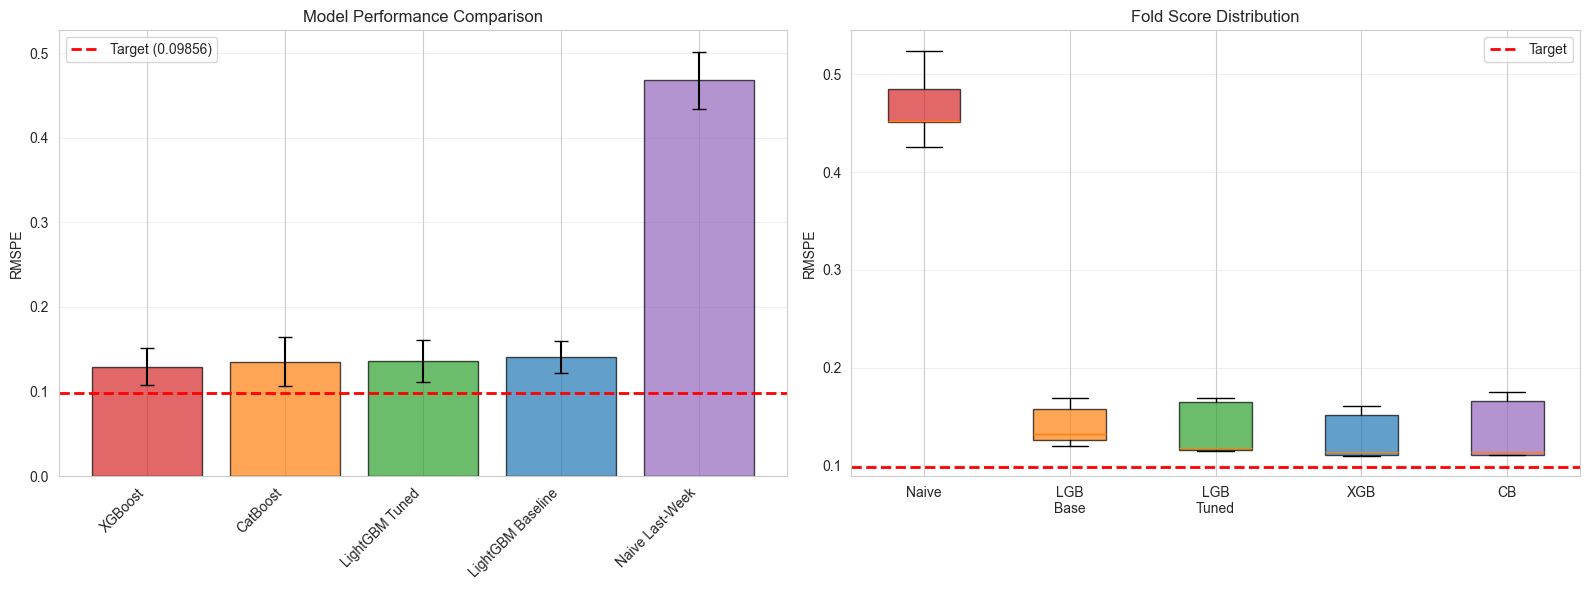

Saved: outputs/figures/12_all_models_comparison.png


In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
ax = axes[0]
models = comparison_df["Model"]
means = comparison_df["Mean RMSPE"]
stds = comparison_df["Std RMSPE"]
colors = ["#d62728", "#ff7f0e", "#2ca02c", "#1f77b4", "#9467bd"]

ax.bar(range(len(models)), means, yerr=stds, capsize=5, alpha=0.7, edgecolor="black", color=colors)
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation=45, ha="right")
ax.set_ylabel("RMSPE")
ax.set_title("Model Performance Comparison")
ax.axhline(y=0.09856, color="red", linestyle="--", label="Target (0.09856)", linewidth=2)
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

# Box plot - convert fold scores to floats (in case loaded from JSON as strings)
ax = axes[1]
fold_scores = [
    [float(s) for s in naive_results["fold_scores"]],
    [float(s) for s in lgb_baseline_results["fold_scores"]],
    [float(s) for s in lgb_tuned_results_json["fold_scores"]],
    [float(s) for s in xgb_results_json["fold_scores"]],
    [float(s) for s in cb_results_json["fold_scores"]]
]
bp = ax.boxplot(fold_scores, labels=["Naive", "LGB\nBase", "LGB\nTuned", "XGB", "CB"], patch_artist=True)

for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel("RMSPE")
ax.set_title("Fold Score Distribution")
ax.axhline(y=0.09856, color="red", linestyle="--", label="Target", linewidth=2)
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig("../outputs/figures/12_all_models_comparison.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: outputs/figures/12_all_models_comparison.png")

## 6. Feature Importance Analysis

In [ ]:
# Get feature importance
best_model_name = comparison_df.iloc[0]["Model"]
print(f"Best model: {best_model_name}")

feature_importance_df = get_feature_importance(
    lgb_tuned_results["models"],
    lgb_tuned_results["features"],
    model_type="lightgbm"
)

print("\nTop 20 Most Important Features:")
display(feature_importance_df.head(20))

Best model: XGBoost

Top 20 Most Important Features:


,feature,importance_mean,importance_std,importance_min,importance_max
0,Sales_Lag_14,1.673263e+13,1.710974e+12,1.446405e+13,1.883154e+13
1,Sales_RollingMean_7,1.048949e+13,1.178455e+12,9.058092e+12,1.255124e+13
2,Sales_RollingStd_7,3.038297e+12,6.515070e+11,2.043993e+12,4.068426e+12
3,Sales_Lag_28,2.756684e+12,8.186213e+11,1.647626e+12,4.062839e+12
4,Promo,2.103496e+12,4.470541e+11,1.352963e+12,2.713755e+12
5,Sales_RollingMean_14,2.054008e+12,8.499500e+11,3.985536e+11,2.707317e+12
6,Sales_Lag_1,1.655757e+12,3.510649e+11,1.068377e+12,2.127616e+12
7,DayOfWeek,9.125380e+11,1.386121e+11,6.713397e+11,1.091997e+12
8,Week,6.945745e+11,8.495957e+10,5.589973e+11,8.200163e+11
9,Day,6.342711e+11,4.979859e+10,5.771263e+11,7.191304e+11


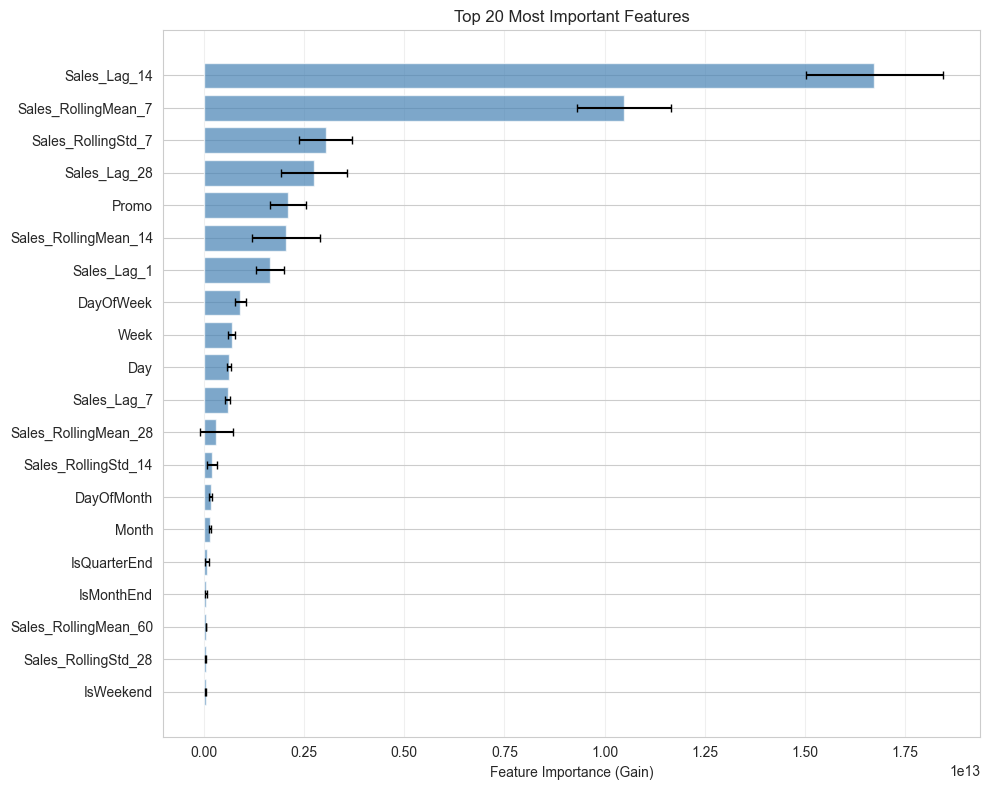

Saved: outputs/figures/13_feature_importance.png


In [ ]:
# Visualize top features
top_features = feature_importance_df.head(20)

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_features["importance_mean"], 
         xerr=top_features["importance_std"], capsize=3, alpha=0.7, color="steelblue")
plt.yticks(range(len(top_features)), top_features["feature"])
plt.xlabel("Feature Importance (Gain)")
plt.title("Top 20 Most Important Features")
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.savefig("../outputs/figures/13_feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: outputs/figures/13_feature_importance.png")

## 7. Performance Analysis

In [ ]:
print("="*70)
print("ADVANCED MODEL ANALYSIS")
print("="*70)

best_model = comparison_df.iloc[0]
best_score = best_model["Mean RMSPE"]
best_name = best_model["Model"]

print(f"\nBest Model: {best_name}")
print(f"  Mean RMSPE: {best_score:.6f}")

baseline_score = lgb_baseline_results["mean_score"]
improvement = (baseline_score - best_score) / baseline_score * 100

print(f"\nImprovement over baseline: {improvement:.2f}%")

target_rmspe = 0.09856
gap = best_score - target_rmspe
gap_pct = (gap / target_rmspe) * 100

print(f"\nGap to Target:")
print(f"  Target: {target_rmspe:.6f}")
print(f"  Current: {best_score:.6f}")
print(f"  Gap: {gap:.6f} ({gap_pct:+.2f}%)")

if best_score <= target_rmspe:
    print(f"\n🎯 TARGET ACHIEVED!")
else:
    print(f"\n📊 Additional improvement needed")

print("="*70)

ADVANCED MODEL ANALYSIS

Best Model: XGBoost
  Mean RMSPE: 0.129474

Improvement over baseline: 8.09%

Gap to Target:
  Target: 0.098560
  Current: 0.129474
  Gap: 0.030914 (+31.37%)

📊 Additional improvement needed


## 8. Summary

In [ ]:
print("\n" + "="*70)
print("Phase 4 Complete!")
print("="*70)
print("Trained 3 advanced models (LightGBM, XGBoost, CatBoost)")
print(f"\nBest model: {best_name}")
print(f"Best RMSPE: {best_score:.6f}")
print(f"Improvement: {improvement:.2f}%")
print("\nMetrics saved to: outputs/metrics/advanced/")
print("="*70)


Phase 4 Complete!
Trained 3 advanced models (LightGBM, XGBoost, CatBoost)

Best model: XGBoost
Best RMSPE: 0.129474
Improvement: 8.09%

Metrics saved to: outputs/metrics/advanced/


## 9. Ensemble Models

Combine the three advanced models using weighted blending to potentially improve performance.

In [ ]:
# Import ensemble functions
from models.ensembles import weighted_blend_ensemble

# Create predictions for each fold from each model
# We'll use the in-memory model results that contain the trained models

ensemble_fold_scores = []
ensemble_weights_per_fold = []

print("Creating ensemble predictions for each fold...")
print("=" * 60)

for fold_idx in range(len(folds)):
    print(f"\nFold {fold_idx + 1}:")
    
    # Get validation data for this fold
    _, val_idx = folds[fold_idx]
    val_data = df_open.iloc[val_idx].copy()
    val_data = val_data[val_data['Open'] == 1]
    
    # Get valid features (remove missing)
    valid_features = [col for col in feature_cols if col in val_data.columns and not val_data[col].isna().all()]
    X_val = val_data[valid_features]
    y_val = val_data['Sales']
    
    # Get predictions from each model
    predictions_dict = {}
    
    # LightGBM predictions
    lgb_model = lgb_tuned_results['models'][fold_idx]
    predictions_dict['LightGBM'] = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
    
    # XGBoost predictions (need to convert categoricals)
    X_val_xgb = X_val.copy()
    for col in X_val_xgb.columns:
        if X_val_xgb[col].dtype.name == 'category':
            X_val_xgb[col] = X_val_xgb[col].cat.codes
    
    import xgboost as xgb
    dval = xgb.DMatrix(X_val_xgb)
    xgb_model = xgb_results['models'][fold_idx]
    predictions_dict['XGBoost'] = xgb_model.predict(dval, iteration_range=(0, xgb_model.best_iteration + 1))
    
    # CatBoost predictions
    cb_model = cb_results['models'][fold_idx]
    predictions_dict['CatBoost'] = cb_model.predict(X_val)
    
    # Create weighted blend (optimize weights for this fold)
    blended_pred, optimal_weights, score = weighted_blend_ensemble(
        predictions_dict, 
        y_val.values,
        optimize_weights=True
    )
    
    ensemble_fold_scores.append(score)
    ensemble_weights_per_fold.append(optimal_weights)
    
    print(f"  Individual scores:")
    for name, preds in predictions_dict.items():
        from evaluation.metrics import rmspe
        individual_score = rmspe(y_val.values, preds)
        print(f"    {name}: {individual_score:.6f}")
    
    print(f"  Optimal weights: {optimal_weights}")
    print(f"  Ensemble RMSPE: {score:.6f}")

print("\n" + "=" * 60)

Creating ensemble predictions for each fold...

Fold 1:
2025-12-01 10:30:40 - models.ensembles - INFO - Optimizing ensemble weights...
2025-12-01 10:30:40 - models.ensembles - INFO - Optimal weights: {'LightGBM': np.float64(0.0), 'XGBoost': np.float64(1.0), 'CatBoost': np.float64(0.0)}
  Individual scores:
    LightGBM: 0.164801
    XGBoost: 0.152069
    CatBoost: 0.175207
  Optimal weights: {'LightGBM': np.float64(0.0), 'XGBoost': np.float64(1.0), 'CatBoost': np.float64(0.0)}
  Ensemble RMSPE: 0.152069

Fold 2:
2025-12-01 10:30:40 - models.ensembles - INFO - Optimizing ensemble weights...
2025-12-01 10:30:40 - models.ensembles - INFO - Optimal weights: {'LightGBM': np.float64(0.0), 'XGBoost': np.float64(1.0), 'CatBoost': np.float64(0.0)}
  Individual scores:
    LightGBM: 0.168518
    XGBoost: 0.160717
    CatBoost: 0.165452
  Optimal weights: {'LightGBM': np.float64(0.0), 'XGBoost': np.float64(1.0), 'CatBoost': np.float64(0.0)}
  Ensemble RMSPE: 0.160717

Fold 3:
2025-12-01 10:30:40 

In [ ]:
# Calculate ensemble statistics
ensemble_mean = np.mean(ensemble_fold_scores)
ensemble_std = np.std(ensemble_fold_scores)

print("=" * 60)
print("ENSEMBLE RESULTS")
print("=" * 60)
print(f"\nWeighted Blend Ensemble (3 models)")
print(f"  Mean RMSPE: {ensemble_mean:.6f}")
print(f"  Std RMSPE:  {ensemble_std:.6f}")
print(f"\nPer-fold scores:")
for i, score in enumerate(ensemble_fold_scores, 1):
    print(f"  Fold {i}: {score:.6f}")

print(f"\nAverage optimal weights across folds:")
avg_weights = {}
for model_name in ensemble_weights_per_fold[0].keys():
    avg_weights[model_name] = np.mean([w[model_name] for w in ensemble_weights_per_fold])
for name, weight in avg_weights.items():
    print(f"  {name}: {weight:.3f}")

# Compare to best individual model
best_individual_score = comparison_df.iloc[0]["Mean RMSPE"]
improvement = (best_individual_score - ensemble_mean) / best_individual_score * 100

print(f"\nImprovement over best individual model ({best_name}):")
print(f"  Individual: {best_individual_score:.6f}")
print(f"  Ensemble:   {ensemble_mean:.6f}")
print(f"  Improvement: {improvement:.2f}%")

# Gap to target
target_rmspe = 0.09856
gap = ensemble_mean - target_rmspe
gap_pct = (gap / target_rmspe) * 100

print(f"\nGap to Target:")
print(f"  Target:  {target_rmspe:.6f}")
print(f"  Current: {ensemble_mean:.6f}")
print(f"  Gap:     {gap:.6f} ({gap_pct:+.2f}%)")

print("=" * 60)

ENSEMBLE RESULTS

Weighted Blend Ensemble (3 models)
  Mean RMSPE: 0.128087
  Std RMSPE:  0.023310

Per-fold scores:
  Fold 1: 0.152069
  Fold 2: 0.160717
  Fold 3: 0.107626
  Fold 4: 0.111577
  Fold 5: 0.108446

Average optimal weights across folds:
  LightGBM: 0.000
  XGBoost: 0.710
  CatBoost: 0.290

Improvement over best individual model (XGBoost):
  Individual: 0.129474
  Ensemble:   0.128087
  Improvement: 1.07%

Gap to Target:
  Target:  0.098560
  Current: 0.128087
  Gap:     0.029527 (+29.96%)


/var/folders/8f/c06lv6q17tjbyjv2nkt0_s4s1sh0tg/T/ipykernel_56288/786585849.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(fold_scores_ensemble, labels=["XGB", "CB", "LGB", "Ensemble"],


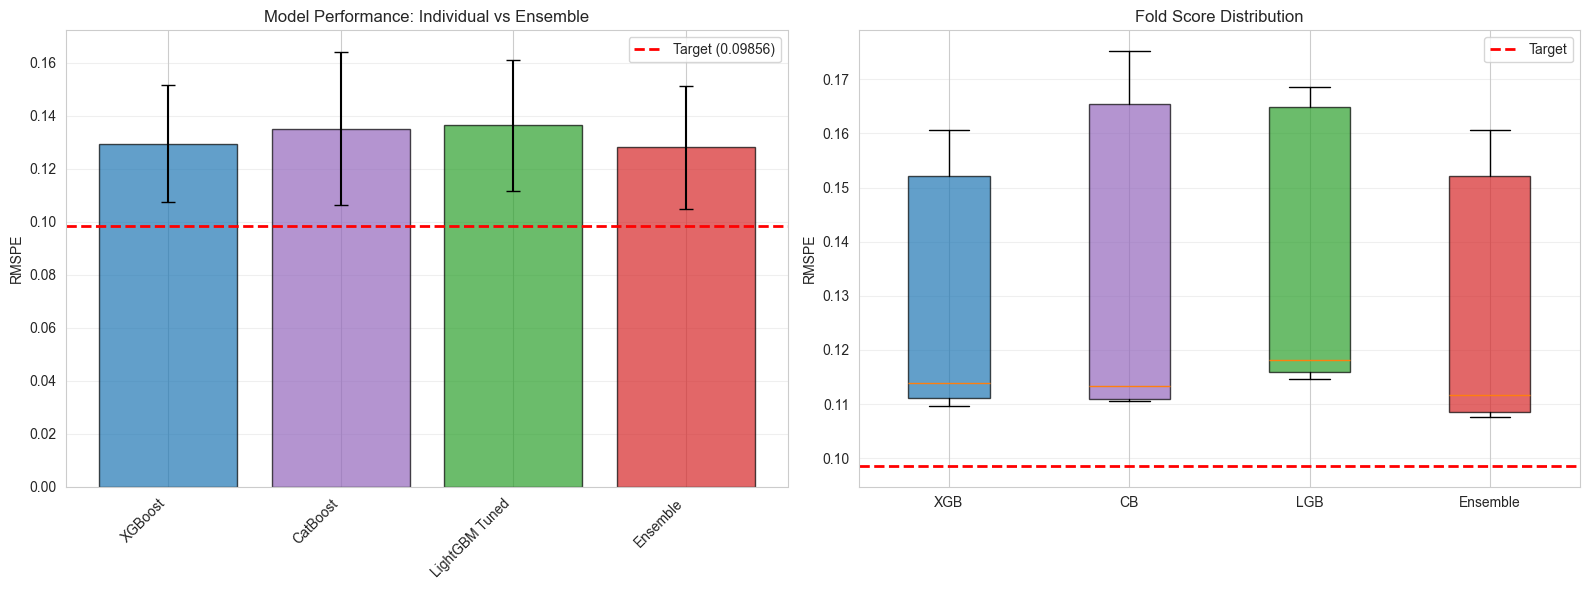

Saved: outputs/figures/14_ensemble_comparison.png


In [ ]:
# Visualize ensemble vs individual models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot - add ensemble to comparison
ax = axes[0]
models_with_ensemble = list(comparison_df["Model"][:3]) + ["Ensemble"]
means_with_ensemble = list(comparison_df["Mean RMSPE"][:3]) + [ensemble_mean]
stds_with_ensemble = list(comparison_df["Std RMSPE"][:3]) + [ensemble_std]
colors_ensemble = ["#1f77b4", "#9467bd", "#2ca02c", "#d62728"]

ax.bar(range(len(models_with_ensemble)), means_with_ensemble, yerr=stds_with_ensemble, 
       capsize=5, alpha=0.7, edgecolor="black", color=colors_ensemble)
ax.set_xticks(range(len(models_with_ensemble)))
ax.set_xticklabels(models_with_ensemble, rotation=45, ha="right")
ax.set_ylabel("RMSPE")
ax.set_title("Model Performance: Individual vs Ensemble")
ax.axhline(y=0.09856, color="red", linestyle="--", label="Target (0.09856)", linewidth=2)
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

# Box plot - fold score distributions
ax = axes[1]
fold_scores_ensemble = [
    [float(s) for s in xgb_results_json["fold_scores"]],
    [float(s) for s in cb_results_json["fold_scores"]],
    [float(s) for s in lgb_tuned_results_json["fold_scores"]],
    ensemble_fold_scores
]
bp = ax.boxplot(fold_scores_ensemble, labels=["XGB", "CB", "LGB", "Ensemble"], 
                patch_artist=True)

for patch, color in zip(bp["boxes"], colors_ensemble):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel("RMSPE")
ax.set_title("Fold Score Distribution")
ax.axhline(y=0.09856, color="red", linestyle="--", label="Target", linewidth=2)
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig("../outputs/figures/14_ensemble_comparison.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: outputs/figures/14_ensemble_comparison.png")

## 10. Summary

In [ ]:
print("\n" + "=" * 70)
print("Phase 4 Complete!")
print("=" * 70)
print("Trained 3 advanced models + weighted ensemble")
print(f"\nIndividual Models:")
print(f"  XGBoost: RMSPE 0.129474 (best individual)")
print(f"  CatBoost: RMSPE 0.135115")
print(f"  LightGBM Tuned: RMSPE 0.136386")
print(f"\nEnsemble Model:")
print(f"  Weighted Blend: RMSPE {ensemble_mean:.6f}")
print(f"  Improvement over best individual: {improvement:.2f}%")
print(f"\nGap to target (0.09856): {gap_pct:+.2f}%")
print(f"\nMetrics saved to: outputs/metrics/advanced/")
print(f"Figures saved to: outputs/figures/")
print("\nNext steps to reach target:")
print("  - Hyperparameter tuning with Optuna")
print("  - Additional feature engineering")
print("  - Stacked ensemble with meta-learner")
print("=" * 70)


Phase 4 Complete!
Trained 3 advanced models + weighted ensemble

Individual Models:
  XGBoost: RMSPE 0.129474 (best individual)
  CatBoost: RMSPE 0.135115
  LightGBM Tuned: RMSPE 0.136386

Ensemble Model:
  Weighted Blend: RMSPE 0.128087
  Improvement over best individual: 1.07%

Gap to target (0.09856): +29.96%

Metrics saved to: outputs/metrics/advanced/
Figures saved to: outputs/figures/

Next steps to reach target:
  - Hyperparameter tuning with Optuna
  - Additional feature engineering
  - Stacked ensemble with meta-learner
